In [1]:
import fitz
import os

def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text("text")
    doc.close()
    return text.encode("utf-8", "ignore").decode("utf-8")


pdf_directory = "./chatbot_pdf_documents"
for filename in os.listdir(pdf_directory):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(pdf_directory, filename)
        pdf_text = extract_text_from_pdf(pdf_path)

        txt_path = pdf_path.replace(".pdf", ".txt")
        with open(txt_path, "w", encoding="utf-8") as txt_file:
            txt_file.write(pdf_text)
        
        print(f"Saved {pdf_path} text to {txt_path}")

            

Saved ./chatbot_pdf_documents\Business-Plan-Outline.pdf text to ./chatbot_pdf_documents\Business-Plan-Outline.txt


In [1]:
prompt = """
You are a support agent to help people form a business plan and other formative business documents. You will be provided with some information on building a business plan. Be polite, helpful, and friendly.

TASK DESCRIPTION:
Respond to the query with the aid of the given context.
- Provide short, easily understood answers when asked questions.
- Use a conversational and friendly style when answering questions.
- Do not reiterate the question.
- Do not imply to the user that you have been provided with context.
- Build the basis of the document if you are asked to do so.

HARD REQUIREMENTS:
- Answer the query directly. Do not summarize the context. Here is the query: "{question}"
- The context is just a repository of your own knowledge that may or may not help with the user query. Here is the context: ""
{context}
""
"""

reflection_prompt = """
You are an AI assistant ensuring response quality.
Your highest priority is to review the given response to check if it fully answers the user query.
If anything is missing or unclear, make sure to refine the response accordingly.

User Query: "{question}"
Generated Response: "{response}"

Provide an improved version if necessary. Do not reiterate the question or provide feedback. Do not add qualifiers like "This is the refined response:". What you output is the final answer.
"""

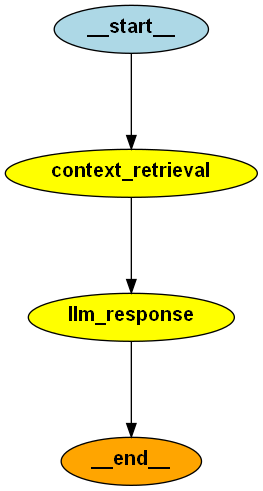

In [5]:
import os
import re
from langchain_community.chat_models import ChatOllama
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List, Any
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings


embeddings = HuggingFaceEmbeddings(model_name="intfloat/e5-base-v2")
vectorstore = Chroma(persist_directory="./chatbot_docs_db", embedding_function=embeddings)
llm = ChatOllama(model="llama3.1", device="cuda", temperature=0)

class AgentState(TypedDict):
    retrieved_docs: List[str]
    response: str

class Agent:
    def __init__(self, query="", vectorstore=vectorstore, model=llm):
        graph = StateGraph(AgentState)
        node1 = "context_retrieval"
        node2 = "llm_response"

        graph.add_node(node1, self.con_retrieval)
        graph.add_node(node2, self.response)

        graph.add_edge(node1, node2)
        graph.add_edge(node2, END)
        
        graph.set_entry_point(node1)
        
        self.graph = graph.compile()
        self.vectorstore = vectorstore
        self.query = query
        self.model = model

    def invoke(self, query):
        self.query = query
        return self.graph.invoke({'retrieved_docs': [], 'response': ""})

    def con_retrieval(self, state: AgentState):
        retrieved_docs = []

        result = self.vectorstore.similarity_search(self.query, k=1)[0]

        retrieved_docs.append(result.metadata['source']+"\n"+result.metadata['source_content'])
                    
        state['retrieved_docs'] = retrieved_docs
        return state

    def response(self, state: AgentState):
        context = "\n\n".join(state['retrieved_docs'])
        formatted_prompt = prompt.format(question=self.query, context=context)

        response = self.model.invoke(formatted_prompt)

        state['response'] = re.sub(r'.*?</think>', '', response.content, flags=re.DOTALL).strip()
        return state
    
from IPython.display import Image

abot = Agent()
Image(abot.graph.get_graph().draw_png())


In [2]:
import os
import re
from langchain_community.chat_models import ChatOllama
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="intfloat/e5-base-v2")
vectorstore = Chroma(persist_directory="./chatbot_docs_db", embedding_function=embeddings)
llm = ChatOllama(model="llama3.1", device="cuda", temperature=0)


class AgentState(TypedDict):
    retrieved_docs: List[str]
    response: str
    history: List[str]
    summarized_history: str
    user_input: str

class ChatBot:
    def __init__(self, vectorstore=vectorstore, model=llm):
        graph = StateGraph(AgentState)
        node1 = "input_handler"
        node2 = "summarize_history"
        node3 = "context_retrieval"
        node4 = "llm_response"
        node5 = "reflect_response"

        graph.add_node(node1, self.input_handler)
        graph.add_node(node2, self.summarize_history)
        graph.add_node(node3, self.con_retrieval)
        graph.add_node(node4, self.response)
        graph.add_node(node5, self.reflect_response)

        graph.add_conditional_edges(node1, self.should_exit, {True: END, False: node2})
        graph.add_edge(node2, node3)
        graph.add_edge(node3, node4)
        graph.add_edge(node4, node5)
        graph.add_edge(node5, node1)  # Loops back after reflection
        
        graph.set_entry_point(node1)
        
        self.graph = graph.compile()
        self.vectorstore = vectorstore
        self.model = model
        self.history = []

    def invoke(self):
        return self.graph.invoke({'retrieved_docs': [], 'response': "", 'history': self.history, 'user_input': ""}, {'recursion_limit': 1000})

    def input_handler(self, state: AgentState):
        user_input = input("You: ")
        state['user_input'] = user_input
        return state
    
    def should_exit(self, state: AgentState):
        return state['user_input'].strip().lower() == "exit"

    def summarize_history(self, state: AgentState):
        if state['history'] != [] and len(state['history']) <= 10:
            summary_prompt = "Summarize this conversation history in a way that is useful to the chatbot:\n" + "\n".join(state['history'][:])
            summary = self.model.invoke(summary_prompt).content.strip()
            self.history = [summary] + state['history'][-2:]
        elif state['history'] != []:
            summary_prompt = "Summarize this conversation history in a way that is useful to the chatbot:\n" + "\n".join(state['history'][-10:-2])
            summary = self.model.invoke(summary_prompt).content.strip()
            self.history = [summary] + state['history'][-2:]

        return state

    def con_retrieval(self, state: AgentState):
        retrieved_docs = []
        results = self.vectorstore.similarity_search(state['user_input'], k=1)
        if results:
            retrieved_docs.append(results[0].metadata['source']+"\n"+results[0].metadata['source_content'])
        state['retrieved_docs'] = retrieved_docs
        return state

    def response(self, state: AgentState):
        context = "\n\n".join(state['retrieved_docs']) if state['retrieved_docs'] else ""
        history_context = "History:\n"+"\n\n".join(self.history) if self.history else ""
        formatted_prompt = prompt.format(question=state['user_input'], context=context + "\n\n" + history_context)
        
        response = self.model.invoke(formatted_prompt).content.strip()
        response_cleaned = re.sub(r'.*?</think>', '', response, flags=re.DOTALL).strip()
        
        state['history'].append(f"User: {state['user_input']}")
        state['history'].append(f"Bot: {response_cleaned}")
        
        state['response'] = response_cleaned
        print(f"User: {state['user_input']}")
        print(f"Bot: {response_cleaned}")
        return state
    
    def reflect_response(self, state: AgentState):
        reflection_input = reflection_prompt.format(question=state['user_input'], response=state['response'])
        refined_response = self.model.invoke(reflection_input).content.strip()
        
        if refined_response:
            state['response'] = refined_response
            state['history'][-1] = f"Bot: {refined_response}"
            print(f"Refined Bot: {refined_response}")
        
        return state


C:\Users\mukoo\AppData\Local\Temp\ipykernel_39596\3161328345.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="intfloat/e5-base-v2")
c:\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


C:\Users\mukoo\AppData\Local\Temp\ipykernel_39596\3161328345.py:10: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory="./chatbot_docs_db", embedding_function=embeddings)
C:\Users\mukoo\AppData\Local\Temp\ipykernel_39596\3161328345.py:11: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="llama3.1", device="cuda", temperature=0)


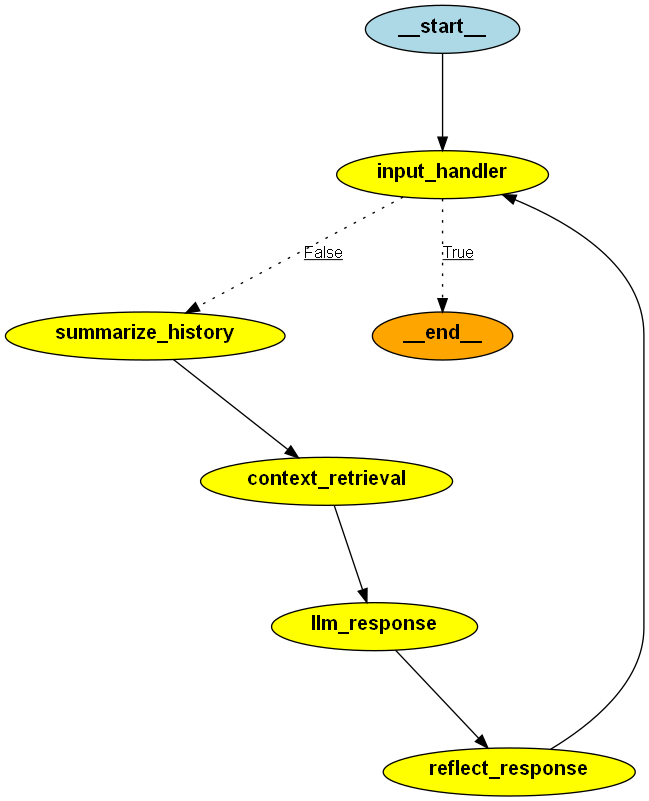

In [26]:
from IPython.display import Image

abot = ChatBot()
Image(abot.graph.get_graph().draw_png())


In [3]:
# llm = ChatOllama(model="deepseek-r1:7b", device="cuda", temperature=0)
abot = ChatBot()
result = abot.invoke()

# print(result['response'])

User: Hi, I'd like help making a business plan
Bot: I'd be happy to help you make a business plan.

To get started, let's begin with the Executive Summary section. This is a brief, one-page summary that represents the various sections of your business plan. It's written last, but it's the most important part of your plan because it gives an overview of your business and its goals.

Can you tell me what kind of business you're planning to start? Is it a retail store, a service-based business, or something else entirely?
Refined Bot: I'd be happy to help you make a business plan.

To get started, let's begin with defining your business concept and goals. This will serve as the foundation for the rest of your plan. Can you tell me what kind of business you're planning to start? Is it a retail store, a service-based business, or something else entirely?

Once we have a clear understanding of your business idea, we can proceed with outlining the various sections of your business plan, inclu

In [4]:
for each in result['history']:
    print(each)
    print("\n-|-|-|-|-|-|-|-|-|-\n")

# print("\n\n".join(abot.history))


User: Hi, I'd like help making a business plan

-|-|-|-|-|-|-|-|-|-

Bot: I'd be happy to help you make a business plan.

To get started, let's begin with defining your business concept and goals. This will serve as the foundation for the rest of your plan. Can you tell me what kind of business you're planning to start? Is it a retail store, a service-based business, or something else entirely?

Once we have a clear understanding of your business idea, we can proceed with outlining the various sections of your business plan, including the Executive Summary, Company Description, Market Analysis, Marketing and Sales Strategy, Financial Projections, and more.

Let's work together to create a comprehensive business plan that meets your specific needs and goals.

-|-|-|-|-|-|-|-|-|-

User: The Urban Grill is a food truck that serves up gourmet, made-to-order burgers, sandwiches, and salads using locally sourced, organic ingredients. The business is structured with a mobile setup that travel

In [15]:
llm = ChatOllama(model="deepseek-r1:7b", device="cuda", temperature=0)
abot = Agent(model=llm)
result = abot.invoke("I'm starting a toy commpany for very crazy toys. Can you make an example business plan for it?")

print(result['response'])

Creating a comprehensive business plan for "Very Crazy Toys" involves several key sections, each addressing different aspects of the company's operations and financials. Below is an organized and elegant presentation of the thought process and structure for the business plan:

---

### **Business Plan for Very Crazy Toys**

#### **1. Executive Summary**
- **Company Overview**: Introduce "Very Crazy Toys," emphasizing its mission to provide unique, innovative toys that cater specifically to children.
- **Mission Statement**: Highlight the company's commitment to creating toys that inspire creativity and joy.
- **Goals**: Outline short-term (e.g., launching in six months) and long-term objectives (e.g., becoming a market leader).
- **Key Features**: Emphasize unique designs, themes, or technologies that set Very Crazy Toys apart from competitors.

#### **2. Background Information**
- **Business Concept**: Describe the idea of Very Crazy Toys, focusing on its unique selling points.
- **Pr

In [16]:
abot2 = Agent()
result2 = abot2.invoke("I'm starting a toy commpany for very crazy toys. Can you make an example business plan for it?")

print(result2['response'])

I'd be happy to help you create a business plan for your toy company.

Here's an example business plan to get us started:

**Cover Page**

* Company Name: Crazy Toys Inc.
* Date: [Current Date]
* Author: [Your Name]

**Executive Summary**

Crazy Toys Inc. is a startup toy company that specializes in creating unique and exciting toys for kids of all ages. Our mission is to provide high-quality, innovative toys that bring joy and excitement to children while also promoting learning and development. We plan to achieve this through a combination of online sales, wholesale partnerships with retailers, and strategic marketing efforts.

**Background Information**

* **Business Concept:** Crazy Toys Inc. will be a manufacturer and distributor of toys, focusing on creating unique and exciting products that cater to the needs of children.
* **Mission Statement:** Our mission is to provide high-quality, innovative toys that bring joy and excitement to children while also promoting learning and de

In [17]:
llm = ChatOllama(model="deepseek-r1:7b", device="cuda", temperature=0)
abot = Agent(model=llm)
result = abot.invoke("""
GreenTech Innovations is a forward-thinking technology company founded in 2015, focused on providing sustainable energy solutions to reduce carbon footprints and promote environmental sustainability. Specializing in solar, wind, and energy storage systems, as well as smart grid solutions and expert consulting services, the company empowers businesses and communities to adopt clean energy technologies. GreenTech Innovations has been recognized as one of the top emerging green energy companies and has successfully implemented renewable energy systems for over 300 commercial clients worldwide, reducing CO2 emissions by over 1 million tons annually. With a mission to drive innovation in the energy sector, the company values sustainability, collaboration, and cutting-edge solutions, envisioning a future where renewable energy powers homes and businesses globally, contributing to a cleaner, more sustainable world for future generations.

Can you provide a marketing and sales plan for GreenTech Innovations?
""")

print(result['response'])

**Marketing and Sales Plan for GreenTech Innovations**

---

### **Executive Summary**
GreenTech Innovations is a leader in providing sustainable energy solutions, specializing in solar, wind, storage systems, and smart grids. With over 300 global clients reducing CO2 emissions by millions of tons annually, we aim to expand our market reach through targeted marketing strategies. Our plan focuses on leveraging our proven track record, competitive advantage, and innovative approach to attract businesses and communities seeking sustainable solutions.

---

### **Market Analysis**
1. **Industry Overview**: The renewable energy sector is growing rapidly, driven by climate change concerns and government incentives.
2. **Target Market**:
   - Businesses (manufacturing, construction, logistics) adopting green technologies.
   - Communities and municipalities looking to reduce carbon footprints.
3. **Competitive Landscape**:
   - Competitors include established solar and wind companies, but Gre

In [18]:
abot2 = Agent()
result2 = abot2.invoke("""
GreenTech Innovations is a forward-thinking technology company founded in 2015, focused on providing sustainable energy solutions to reduce carbon footprints and promote environmental sustainability. Specializing in solar, wind, and energy storage systems, as well as smart grid solutions and expert consulting services, the company empowers businesses and communities to adopt clean energy technologies. GreenTech Innovations has been recognized as one of the top emerging green energy companies and has successfully implemented renewable energy systems for over 300 commercial clients worldwide, reducing CO2 emissions by over 1 million tons annually. With a mission to drive innovation in the energy sector, the company values sustainability, collaboration, and cutting-edge solutions, envisioning a future where renewable energy powers homes and businesses globally, contributing to a cleaner, more sustainable world for future generations.

Can you provide a marketing and sales plan for GreenTech Innovations?
""")

print(result2['response'])

I'd be happy to help you create a marketing and sales plan for GreenTech Innovations.

To get started, let's break down the key components of a marketing and sales plan. We'll need to consider the following:

1. **Market Analysis**: Who is our target market? What are their needs and pain points?
2. **Competitive Analysis**: Who are our competitors? How do we differentiate ourselves from them?
3. **Marketing Strategies**: What tactics will we use to reach and engage with our target market?
4. **Sales Plan**: How will we convert leads into customers?

Based on the information provided about GreenTech Innovations, I'll start by outlining a potential marketing and sales plan.

**Market Analysis**

* Target Market: Commercial clients seeking sustainable energy solutions
* Needs and Pain Points:
	+ Reducing carbon footprint and environmental impact
	+ Increasing energy efficiency and cost savings
	+ Meeting regulatory requirements for renewable energy adoption

**Competitive Analysis**

* Co

In [19]:
result2['retrieved_docs'][0]

'Business-Plan-Outline.pdf\n1\nsbtdc.org\nBusiness Plan Outline\nI. COVER PAGE \nII. TABLE OF CONTENTS \nIII. EXECUTIVE SUMMARY \nThe executive summary is a brief, one-page summary representing the various sections of your business plan. It is written last, but \nit is the most important part of your plan.  \nIV. BACKGROUND INFORMATION\nNote: If your business will be a seasonal business, make sure the seasonality is reflected in your narrative and financial projec-\ntions with appropriate footnotes. \nA.\t Business concept \na.\t\nMission statement \nb.\t\nGoals and objectives of business \nc.\t\nDescription of business \nB.\t\nAnswer as many of the following questions as are appropriate: \na.\t\nWhat business are you in? \ni.\t Merchandising \nii.\t Manufacturing \niii.\t Wholesale\niv.\t Service \nb.\t\nWhat is the nature of your product(s) or service(s) \nc.\t\nWhat will be special about your business? \nC.\t What market do you intend to serve? \na.\t\nWhat is the total market? \nb.

Tools

In [ ]:
from langchain.chat_models import ChatOllama
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent
from langchain.prompts import StringPromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.schema import AgentAction, AgentFinish
from typing import List, Union
import re

class CompanyAnalysisAgent:
    def __init__(self, model="llama3.1", device="cuda"):
        # Initialize the LLM
        self.llm = ChatOllama(model=model, device=device, temperature=0)
        
        # Custom tools for each question type
        self.tools = [
            Tool(
                name="Business Details",
                func=lambda x: "Extracted business details from the description.",
                description="Use this tool to extract general business details."
            ),
            Tool(
                name="Problem and Solution",
                func=lambda x: "Extracted problem and solution information.",
                description="Use this tool to identify the problem being solved and the company's solution."
            ),
            Tool(
                name="Market Analysis",
                func=lambda x: "Extracted market analysis information.",
                description="Use this tool for market opportunity and competitive landscape analysis."
            ),
            Tool(
                name="Customer Information",
                func=lambda x: "Extracted customer-related information.",
                description="Use this tool for customer description and acquisition strategy."
            ),
            Tool(
                name="Revenue and Risks",
                func=lambda x: "Extracted revenue model and risk information.",
                description="Use this tool for revenue model and risk assessment."
            ),
        ]
        
        # Custom Prompt Template
        self.prompt = self._create_prompt_template()
        
        # Output Parser
        self.output_parser = self._create_output_parser()
        
        # LLM Chain
        self.llm_chain = self._create_llm_chain()
        
        # Agent Executor
        self.agent_executor = self._create_agent_executor()

    def _create_prompt_template(self):
        class CustomPromptTemplate(StringPromptTemplate):
            template: str
            tools: List[Tool]
            input_variables: List[str]
            
            def format(self, **kwargs) -> str:
                intermediate_steps = kwargs.pop("intermediate_steps", [])
                thoughts = ""
                for action, observation in intermediate_steps:
                    thoughts += action.log
                    thoughts += f"\nObservation: {observation}\nThought: "
                kwargs["agent_scratchpad"] = thoughts
                kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
                kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
                return self.template.format(**kwargs)

        return CustomPromptTemplate(
            template="""Company Description: {input}
    
Question: {question}

{tools}

Based on the company description and the question, use the most appropriate tool to gather information. Then, provide a concise and relevant answer to the question as if you are the company representative.

FOLLOW THESE REQUIREMENTS:
- Do not say you are 'attempting' to answer the question or provide any disclaimers.
- Do not make any references to yourself.
- If you do not have enough information to answer the question, output 'Information not provided'.
- If you are not sure about specific technical details, avoid making them up. If you lack enough details that you cannot provide an answer firmly based in the company description, output 'Information not provided'.
- Provide the answer in passive voice as if you are the company representative.
- Use plain text without any formatting or special characters.
- Be descriptive and provide concrete detail when possible.

{agent_scratchpad}
""",
            tools=self.tools,
            input_variables=["input", "question", "tools", "agent_scratchpad"]
        )

    def _create_output_parser(self):
        class CustomOutputParser:
            def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
                if "Final Answer:" in llm_output:
                    return AgentFinish(
                        return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                        log=llm_output,
                    )
                regex = r"Action: (.*?)[\n]*Action Input: (.*)"
                match = re.search(regex, llm_output, re.DOTALL)
                if match:
                    action = match.group(1).strip()
                    action_input = match.group(2).strip()
                    return AgentAction(tool=action, tool_input=action_input, log=llm_output)
                raise ValueError(f"Could not parse LLM output: {llm_output}")
        
        return CustomOutputParser()

    def _create_llm_chain(self):
        return LLMSingleActionAgent(
            llm=self.llm,
            prompt=self.prompt,
            output_parser=self.output_parser,
            stop=["\nObservation:"],
        )

    def _create_agent_executor(self):
        memory = ConversationBufferMemory(memory_key="chat_history")
        return AgentExecutor.from_agent_and_tools(
            agent=self.llm_chain,
            tools=self.tools,
            memory=memory,
            verbose=True
        )

    def analyze_company(self, company_description: str, question: str):
        """
        Analyze a company based on a description and a specific question
        
        Args:
            company_description (str): Detailed description of the company
            question (str): Specific question about the company
        
        Returns:
            str: Analysis result
        """
        try:
            response = self.agent_executor.run(
                input=company_description,
                question=question
            )
            return response
        except Exception as e:
            return f"An error occurred: {str(e)}"

def main():
    # Example usage
    agent = CompanyAnalysisAgent()
    
    company_desc = """
    TechInnovate is a cutting-edge AI startup developing advanced machine learning solutions 
    for predictive maintenance in manufacturing. The company uses deep learning algorithms 
    to predict equipment failures before they occur, helping factories reduce downtime and 
    maintenance costs.
    """
    
    # Example questions
    questions = [
        "What problem does the company solve?",
        "What is the company's primary technology?",
        "Who are the target customers?",
        "What is the potential market size?"
    ]
    
    for question in questions:
        print(f"\nQuestion: {question}")
        result = agent.analyze_company(company_desc, question)
        print(f"Answer: {result}")

if __name__ == "__main__":
    main()